In [1]:
%matplotlib widget

In [2]:
import xtrack as xt
import numpy as np
import matplotlib.pyplot as plt

In [3]:
env = xt.Environment()
env.call('../fccee_z_lattice.py')

In [4]:
env.vars.load_json('strengths_quads_00_arc_cell.json')
env.vars.load_json('strengths_quads_01_ffccsyl.json')
env.vars.load_json('strengths_quads_02_ffccsxl.json')
env.vars.load_json('strengths_quads_03_ffccsyr.json')
env.vars.load_json('strengths_quads_04_ffccsxr.json')
env.vars.load_json('strengths_quads_05_ffds_lr.json')
env.vars.load_json('strengths_quads_06_straight.json')

env.vars.load_json('strengths_sext_00_arc_cell.json')

In [5]:
# Select machine portion
line = env['fccee_p_ring']
section = line.select('mid_cell_edge_r::1','mid_cell_edge_l::2')

In [6]:
# Twiss arc mid cells to get boundary conditions
cell1 = line.select('mid_cell_edge_l::1','mid_cell_edge_r::1')
cell2 = line.select('mid_cell_edge_l::2','mid_cell_edge_r::2')

tw_cell_1 = cell1.twiss4d()
twinit_cell_1_r = tw_cell_1.get_twiss_init('mid_cell_edge_r')
tw_cell_2 = cell2.twiss4d()
twinit_cell_2_l = tw_cell_1.get_twiss_init('mid_cell_edge_l')

In [7]:
tw_no_ip_sext = section.twiss(init=twinit_cell_1_r,
                    compute_chromatic_properties=True)

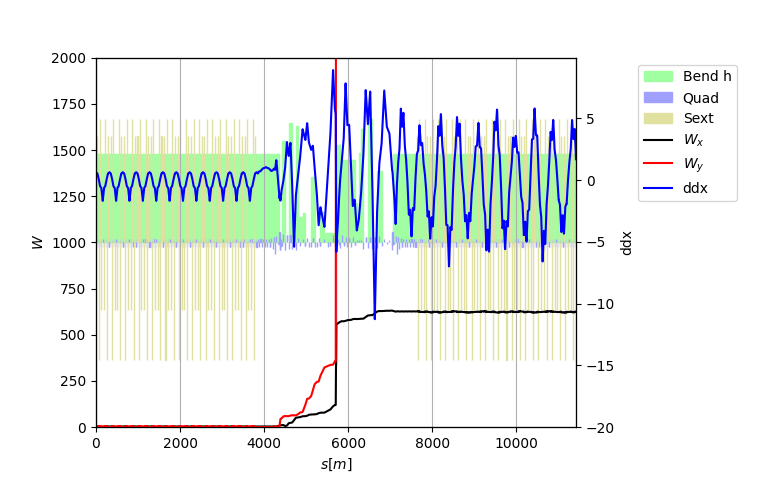

In [8]:
# W functions and second order dispersion before match
pp = tw_no_ip_sext.plot(yl='wx_chrom wy_chrom', yr='ddx')
pp.ylim(left_lo=0, left_hi=2000, right_lo=-20)

### Start by using chromatic correction sextupoles to minimize W at IP (from the left and from the right)

In [9]:
opt_w_left = section.match(
    name='w_left',
    solve=False,
    init=twinit_cell_1_r,
    compute_chromatic_properties=True,
    vary=xt.VaryList(['ksfx1l', 'ksdy1l'], step=1e-3),
    targets=xt.TargetSet(wx_chrom=0, wy_chrom=0, at='ip_mid')
)
opt = opt_w_left
opt.step(10)

# Match from right to left
opt_w_right = section.match(
    name='w_right',
    solve=False,
    init=twinit_cell_2_l,
    compute_chromatic_properties=True,
    vary=xt.VaryList(['ksfx1r', 'ksdy1r'], step=1e-3),
    targets=xt.TargetSet(wx_chrom=0, wy_chrom=0, at='ip_mid')
)
opt = opt_w_right
opt.step(10)

                                             
Optimize [w_left] - start penalty: 4795                         
Matching: model call n. 68 penalty = 1.1341e+01              
Optimize [w_left] - end penalty:  11.3406                            
                                             
Optimize [w_right] - start penalty: 4923                         
Matching: model call n. 68 penalty = 8.0820e+00              
Optimize [w_right] - end penalty:  8.08196                            


In [10]:
# Match W functions to those of the arcs
opt_close_w = section.match(
    name='close',
    solve=False,
    init=twinit_cell_1_r,
    compute_chromatic_properties=True,
    vary=xt.VaryList(['ksfx1l', 'ksdy1l', 'ksfx1r', 'ksdy1r'], step=1e-3),
    targets=[xt.TargetSet(ax_chrom=twinit_cell_1_r.ax_chrom,
                         ay_chrom=twinit_cell_1_r.ay_chrom,
                         bx_chrom=twinit_cell_1_r.bx_chrom,
                         by_chrom=twinit_cell_1_r.by_chrom,
                         at=xt.END),
            xt.TargetSet(wx_chrom=xt.LessThan(10), wy_chrom=xt.LessThan(10),
                         at='ip_mid')]
)
opt = opt_close_w
opt.step(20)

                                             
Optimize [close] - start penalty: 5.354                         
Matching: model call n. 157 penalty = 4.0466e+00              
Optimize [close] - end penalty:  4.0466                            


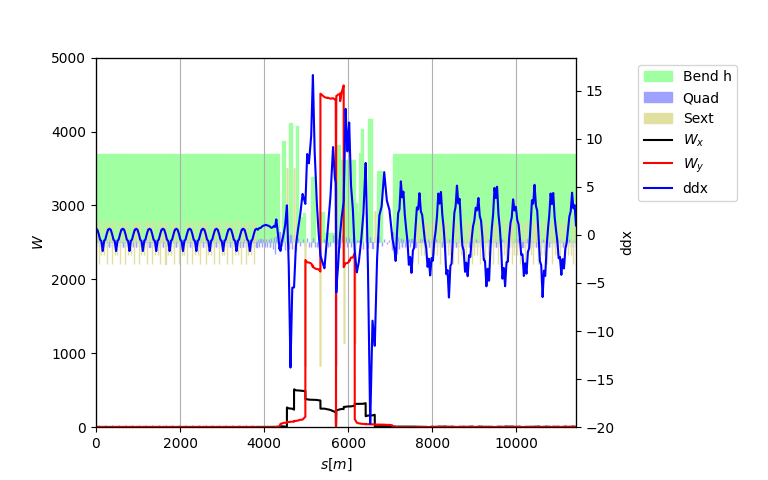

In [11]:
# W functions and second order dispersion before match
pp = opt.plot(yl='wx_chrom wy_chrom', yr='ddx')
pp.ylim(left_lo=0, left_hi=5000, right_lo=-20)